In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [0]:
allStateData = pd.read_csv("us-states.csv")
#California
stateName = "New York"
eachStateData = allStateData[allStateData["state"]==stateName]
z = eachStateData['cases']
orig = z.copy()
orig[1:] = np.diff(z)
eachStateData['ActualCases'] = orig

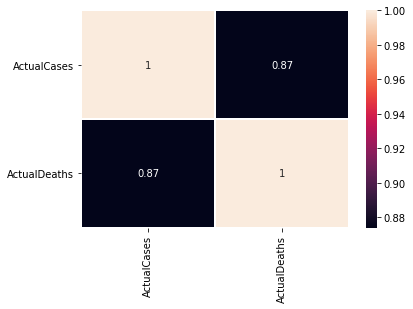

(0.8368057677470356, 0.8368057677470356)


In [0]:
y = eachStateData['deaths']
orig_y = y.copy()
orig_y[1:] = np.diff(y)
eachStateData['ActualDeaths'] = orig_y

import seaborn as sns

corr_data = eachStateData[['ActualCases', 'ActualDeaths']].corr(method='spearman')


sns.heatmap(corr_data,
            annot=True,
            linewidths=0.4,
            annot_kws={"size": 10})

plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()

def correlationfunc(x,y):
    cc1 = np.correlate(x - x.mean(), y - y.mean())[0] # Remove means
    cc1 /= (len(x) * x.std() * y.std()) #Normalise by number of points and product of standard deviations
    cc2 = np.corrcoef(x, y)[0, 1]
    return(cc1, cc2)

a=np.array(eachStateData['ActualCases'])
b=np.array(eachStateData['ActualDeaths'])
print(correlationfunc(a,b))

# def autocorr(self, lag=1):
#     return self.corr(self.shift(lag))

# autocorr(eachStateData['ActualDeaths'])

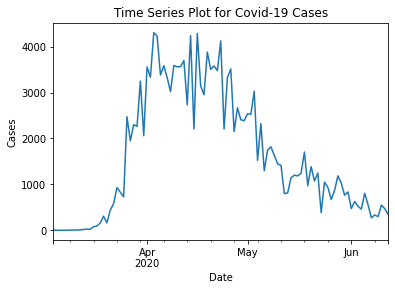

In [0]:
from matplotlib import pyplot
eachStateData["ActualCases"].plot()
pyplot.title("Time Series Plot for Covid-19 Cases")
pyplot.xlabel("Date")
pyplot.ylabel("Cases")
pyplot.show()

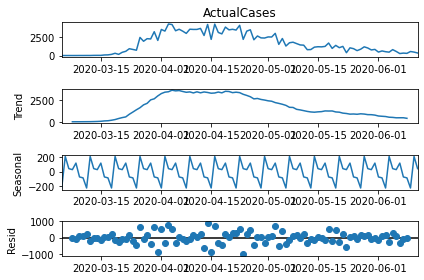

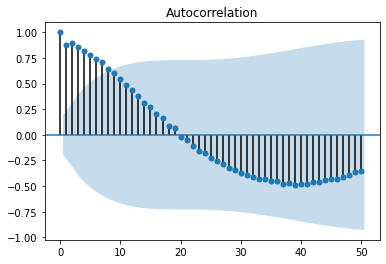

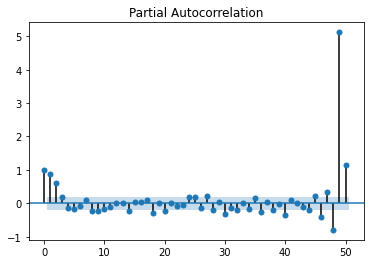

In [0]:
series = eachStateData['ActualCases']
series.index = pd.to_datetime(eachStateData['date'])
result = seasonal_decompose(series, model='additive')
result.plot()
# series.plot()
plot_acf(series, lags = 50)
plot_pacf(series, lags = 50)
pyplot.show()

In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [0]:
# load the dataset
dataframe = eachStateData["ActualCases"]
dataset = dataframe.values
dataset = dataset.astype('float32')

In [0]:
# normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
dataset = dataset.reshape(-1, 1)
# dataset = scaler.fit_transform(dataset)

In [0]:
# # fix random seed for reproducibility
np.random.seed(5)

In [0]:
# split into train and test sets
look_back=[1,7]
model_list = []
validation_loss = []
trainX_list = []
testX_list = []
trainY_list = []
testY_list = []
for look in look_back:
  train_size =  int(len(dataset) * 0.80)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size-look:train_size + test_size,:]
  # reshape into X=t and Y=t+1
  trainX, trainY = create_dataset(train, look)
  testX, testY = create_dataset(test, look)
  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
  testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
  trainX_list.append(trainX)
  testX_list.append(testX)
  trainY_list.append(trainY)
  testY_list.append(testY)
  model = Sequential()
  model.add(LSTM(50, input_shape=(look, 1), activation='relu', return_sequences=True))
  model.add(Dropout(0.4))
  model.add(LSTM(30, activation='relu', return_sequences=True))
  model.add(Dropout(0.3))
  model.add(LSTM(30, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='mean_squared_error', optimizer='adam')  
  train_history = model.fit(trainX, trainY, epochs=20, verbose=0, batch_size=20, validation_data=(testX, testY))
  print(train_history.history['val_loss'][-1])
  validation_loss.append(train_history.history['val_loss'][-1])
  model_list.append(model)

403080.3426339286
221552.10267857142


In [0]:
minIndex = validation_loss.index(min(validation_loss))
model_to_use = model_list[minIndex]

In [0]:
trainX = trainX_list[minIndex]
testX = testX_list[minIndex]
trainY = trainY_list[minIndex]
testY = testY_list[minIndex]

In [0]:
# make predictions
trainPredict = model_to_use.predict(trainX)
testPredict = model_to_use.predict(testX)

In [0]:
# invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])

# print(trainY, trainPredict)

In [0]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1078.63 RMSE
Test Score: 470.69 RMSE


In [0]:
def mean_absolute_percentage_error(y_true, y_pred):
  print(y_true, y_pred) 
  # y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
# calculate root mean squared error
trainScore = math.sqrt(mean_absolute_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f MAP' % (trainScore))
testScore = math.sqrt(mean_absolute_error(testY, testPredict[:,0]))
print('Test Score: %.2f MAP' % (testScore))

Train Score: 28.33 MAP
Test Score: 20.05 MAP


In [0]:
testPredict[:,0]

array([1494.9646 ,  852.01   , 1332.4727 ,  770.61694, 1682.0848 ,
       1693.148  , 1505.2231 ,  297.7496 , 1048.9637 ,  712.9402 ,
        787.74854, 1067.9453 ,  930.9469 , 1379.0276 ,  635.8346 ,
        693.0701 ,  567.6725 ,  735.59467,  611.83765,  948.4225 ,
        806.34375], dtype=float32)

In [0]:
testY

array([ 385., 1050.,  938.,  672.,  864., 1187., 1029.,  764.,  837.,
        473.,  627.,  523.,  462.,  806.,  557.,  271.,  333.,  299.,
        550.,  470.,  348.], dtype=float32)

In [0]:
!pip install pmdarima

80 21 101
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1526.203, BIC=1536.623, Time=0.046 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1578.482, BIC=1583.692, Time=0.011 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1527.071, BIC=1534.886, Time=0.025 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1538.885, BIC=1546.701, Time=0.108 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1576.485, BIC=1579.090, Time=0.017 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=1525.975, BIC=1539.001, Time=0.166 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=1524.604, BIC=1535.025, Time=0.044 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=1525.231, BIC=1538.257, Time=0.037 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=1523.835, BIC=1539.466, Time=0.334 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=1526.950, BIC=1545.186, Time=0.289 seconds
Fit ARIMA(3,1,2)x(0,0,0,0)

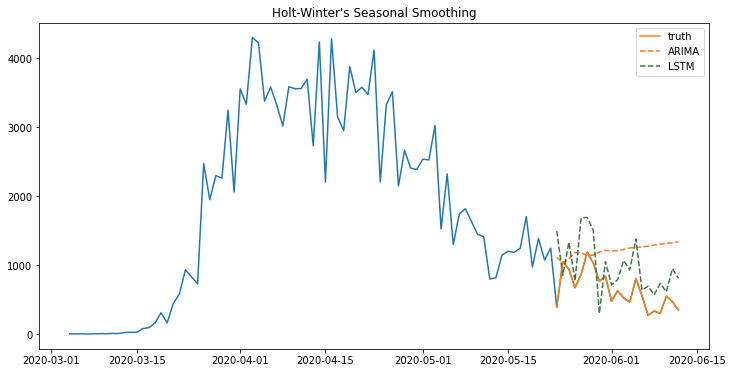

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")



allStateData = pd.read_csv("us-states.csv")
#California
eachStateData = allStateData[allStateData["state"]==stateName]
z = eachStateData['cases']
orig = z.copy()
orig[1:] = np.diff(z)
eachStateData['ActualCases'] = orig

series = eachStateData['ActualCases']
series.index = pd.to_datetime(eachStateData['date'])
result = seasonal_decompose(series, model='additive')
# result.plot()
# series.plot()
# plot_acf(series, lags = 50)
# plot_pacf(series, lags = 50)
# pyplot.show()

# load the dataset
dataframe = eachStateData["ActualCases"]
dataset = dataframe.values

dateDataFrame =  eachStateData["date"]
dateDataSet = dateDataFrame.values

dataset = dataset.astype('double')

# dataset = dataset.reshape(-1, 1)
# dateDataSet = dateDataSet.reshape(-1, 1)

train_size =  int(len(dataframe) * 0.80)
test_size = len(dataframe) - train_size
print(train_size, test_size,len(dataframe))
train, test = dataset[0:train_size], dataset[train_size:]
train_date, test_date = dateDataSet[0:train_size], dateDataSet[train_size:]

train_series = pd.DataFrame(train, index = pd.to_datetime(train_date), columns = ['cases'])
test_series = pd.DataFrame(test, index = pd.to_datetime(test_date), columns= ['cases'])


model = ExponentialSmoothing(train_series, trend="add", seasonal="add")
model2 = ExponentialSmoothing(train_series, trend="add", seasonal="add", damped=True)
fit = model.fit()
pred = fit.forecast(test_size)
fit2 = model2.fit()
pred2 = fit2.forecast(test_size)


sse1 = np.sqrt(np.mean(np.square(test_series["cases"].values - pred)))
sse2 = np.sqrt(np.mean(np.square(test_series["cases"].values - pred2)))


stepwise_model = auto_arima(series, start_p=1, start_q=1,
                           max_p=6, max_q=6,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())
stepwise_model.fit(train_series)
future_forecast = stepwise_model.predict(n_periods=test_size)
# print(future_forecast, test_series["cases"].values)

testScore = math.sqrt(mean_absolute_error(future_forecast, test_series["cases"].values))
print('Test Score: %.2f MAP' % (testScore))
testScore = math.sqrt(mean_squared_error(future_forecast, test_series["cases"].values))
print('Test Score: %.2f RMSE' % (testScore))
testScore = math.sqrt(mean_absolute_error(testY, testPredict[:,0]))
print('Test Score: %.2f MAP' % (testScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print(sse1, sse2)


pred_Series = pd.DataFrame(future_forecast, index = pd.to_datetime(test_date), columns= ['cases'])
pred_lstm = pd.DataFrame(testPredict[:,0],index = pd.to_datetime(test_date), columns= ['cases'])
fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(train_series.index, train_series.values);
ax.plot(series.index, series.values);
ax.plot(test_series.index, test_series.values, label='truth');
ax.plot(pred_Series.index, pred_Series.values, linestyle='--', color='#ff7823', label="ARIMA");
ax.plot(test_series.index, pred_lstm.values, linestyle='--', color='#3c763d', label="LSTM"); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");
plt.show()